## Import Some Stuff

In [2]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

## Define a few functions that we will use for each object

In [3]:
def F_nu(t_p,nu_p,F_nup,nu_sed):
    '''Calculates a Synchrotron Self-Absorbed Spectrum for given input parameters.
    
    Parameters:
    t_p (days): Time of SSA peak - should be single number
    nu_p (GHz): Frequency of SSA peak - should be single number
    F_nup (mJy): Flux of SSA peak - should be single number
    nu (GHz): Frequencies at which you want the SSA spectrum to be calculated at. Likely an array.
    
    Outputs:
    Fnu (mJy): the flux of the SSA. This is an array with values associated with each value of input array nu.
    '''
    
    m = 0.88 #using stAandard model
    p = 3.0 #using standard model
    a = (2*m)+0.5
    b = (p+5-(6*m))/2
    t=t_p
    Fnu = F_nup*1.582*(t/t_p)**a*(nu_sed/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu_sed/nu_p)**(-(p+4)/2)))
    
    return Fnu


def SSA_props(t_p,nu_p,F_nup,D,f=0.5,alpha=1,vw=100,epsilon_b=0.1):
    '''Calculates Synchroton Self-Absorption properties for given input parameters.
    
    Inputs:
    t_p (days): Time of SSA peak - likely a single number
    nu_p (GHz): Frequency of SSA peak - likely a single number
    F_nup (mJy): Flux of SSA peak - likely a single number
    D (Mpc): distance to SN - likely a single number
    f (unitless): filling factor (fraction of emitting region). default is 0.5
    alpha (unitless): ratio charged particles to magnetic field (epsilon_e/epsilon_b). default 1
    v_w (km/s): wind speed. default = 100
    epsilon_b (unitless): fraction of shock energy into B-fields. default = 0.1
    
    Outputs:
    R (cm): radius of material 
    B : magnetic field flux
    E : intermal energy of emitting material
    v (km/s): expansion velocity of material
    M (1d-5 solar masses per year): inferred mass loss rate of progenitor'''
    

    #Radius
    R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

    # Magnetic field flux
    B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

    #Internal energy of the emitting material
    E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

    #expansion velocity in km/s
    v = (R/t_p)*1.1574e-10

    #pre-explosion mass-loss in 1e-5 solar mass per year
    M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(vw/1000)
    
   

    return R,B,E,v,M


def taufreefree(M,R,nu):
    '''Calculates the free free optical depth for a given set of parameters.
    
    Inputs:
    M (1d-5 solar masses per year): mass loss rate
    R (cm): radius of emitting material
    nu (GHz): Frequencies at which you want tau-ff to be calculated at. Likely an array.
    
    Outputs:
    tau_ff (unitless): the free-free optical depth, calculated at same frequences as input array nu'''

    Z_ave = 5.4  # Average metallicity 1= pure H. 5.4 for a massive star
    miu = 1.9 # mean molecular weight of electrons. 1= pure H  1.9 is for a massive star.
    vw_cgs = 100 * 1e5 # assumed wind velocity in cgs (cm/s). Take this as 1000 * 10^5 for now. (i.e. 1000 km/s in cgs)
    T = 10**4 # temperature of the material absorbing in K.  10^4 is a good starting point. 
        
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units
    
    tau_ff = 2.021e25*M_cgs**2*Z_ave/(miu**2*nu**(2.1)*R**3*vw_cgs**2*T**(1.35))  
    
    return tau_ff

def den(M,R):
    vw_cgs = 100 * 1e5
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units 
        #density of the CSM
    density = M_cgs/(4*3.142*R**2*vw_cgs)
    
    return density
#freqs,SED = F_nu(1224.288326 , 8,  0.0272)       
#R2,B2,E2,v2,M2 = SSA_props(1224.288326 , 8,  0.0272,880) 
#tauff=taufreefree(M2,R2,freqs)
#tauff=taufreefree(4,3e14,np.array([2,5,7]))
#print(freqs)
#print(tauff)
#print(R2,B2,E2,v2,M2)

## Define a Grid in F_np and n_p that you want to calculate SSA+FFA spectra and check whether they are allowed by your data.

In [4]:
# for second epoch non detection of PS11aop
### Define parameters that are specific to the supernova you want to model:###
t_p = 1361.509031# time of observation in days #1261.509031#
D = 1070.14 # distance to SN in Mpc
F_det= 0.0404 #0.0404 # flux of upper limit in mJy
F_det_err = 0.0075 
nu_det = 8 # frequency of upper limit in GHz
file_out = 'PS11aopfirst_ParameterSpace.csv' #File that you will save the results in.


### Define the grid of F_p and nu_p that you want to search over:###

F_p = np.logspace(np.log10(0.001),np.log10(1.0),num=50) #mJy (this is an array evenly spaced in log between 0.01 annd 1)
nu_p = np.logspace(np.log10(0.05),np.log10(50),num=50) #GHz (this is an array evenly spaced in log between 0.5 annd 50)


### Define array of frequencies to calculate the SSA and SSA+FFA spectrum at ###
nu_sed = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

### Define empty arrays of the values that you want to save for each value in the grid you are searching over: ###
Fp_g = [] #peak flux
nup_g =[] #peak frequency
R_g =[] #radius
B_g = [] #Bfield
vsh_g = [] #velocity of shock
M_g = [] #mass loss rate
den_g = []
RuledOut_g = [] #flag for whether it is ruled out

######### SEARCH OVER GRID ############

for F in F_p:
    for nu in nu_p:
        #calculate SSA
        SSA_sed = F_nu(t_p,nu,F,nu_sed)
        
        #calculate Mass loss rate, Radius, velocity, etc.
        R,B,E,v,M = SSA_props(t_p,nu,F,D)
        
        #calculate the density of the CSM
        density = den(M,R)
       
        #calculate tau_ff
        tauff = taufreefree(M,R,nu_sed)
        
        #Correct SED for FFA:
        SSA_FFA_sed = SSA_sed*np.exp(-tauff)
        
        
        #Interpolate this SSA+FFA to the frequency of your data point:
        flux_test = np.interp(nu_det, nu_sed, SSA_FFA_sed)
        #NB: in this case 0.0318, but we should be writing this code as generally as possible.
        F_upper = F_det + F_det_err
        F_lower = F_det - F_det_err

        if (flux_test > F_upper):
            RuledOut = True
        if (flux_test < F_lower):
            RuledOut = True
        else:
            RuledOut = False
        #Evaluate if this SED is allowed by your data.
        #if 0.04 <= flux_test < 0.05:
       # if flux_test < F_ul:
            #RuledOut = False
       # else:
            #RuledOut = True
            
            
        # Append the values from this loop into the arrays that we defined above:
        
        Fp_g.append(F) 
        nup_g.append(nu) 
        R_g.append(R) 
        B_g.append(B) 
        vsh_g.append(v) 
        M_g.append(M)
        den_g.append(density)
        RuledOut_g.append(RuledOut) 
 
        #It will now go on to the next set in the loop:
    
# Now it has gone over the whole loop. So write out the results into a data file that you can use later:
data = [Fp_g,nup_g,R_g,B_g,vsh_g,M_g,den_g,RuledOut_g]
names = ['F_peak','nu_peak','Radius','Bfield','v_shock','Mdot','den','RuledOut']
ascii.write(data,file_out,names=names,overwrite=True)


In [14]:
np.shape(RuledOut_g)

(2500,)

## Make a plot that shows what regions are ruled out versus in based on the data file you just wrote out:
(I think this might show that we may want to refine what grid of Fp and nu_p we are searching over, but this is pretty good. In this plot red are models that are ruled out and grey are ones that are still allowed).

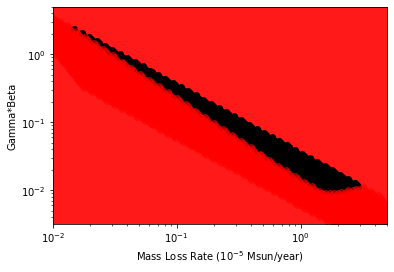

In [12]:
# either epoch or detection PS11aop8x_ParameterSpace.csv is for first epoch detection, PS11aopx_ParameterSpace.csv is for second epoch non detection at 10 GHz
file_in = 'PS11aopfirst_ParameterSpace.csv'
data_plot = ascii.read(file_in)

gammabeta = data_plot['v_shock']*(1/3e5)



plt.figure()

for i in range(len(data_plot)):
    if data_plot['RuledOut'][i] == 'True':
        plt.plot(data_plot['Mdot'][i],gammabeta[i],'ro',alpha=0.5)
    else:
        plt.plot(data_plot['Mdot'][i],gammabeta[i],'ko')# label ='PS11aop8')#,alpha=0.2)

plt.yscale('log')
plt.xscale('log')
x =np.linspace(10,10**(-2),9)
y1 = np.linspace(10**(-3),10,9) 

plt.fill_between(x, y1, 0,
                 facecolor="red", # The fill color
                 color='red',       # The outline color
                 alpha=0.9)      
plt.xlim(1e-2,5)
plt.ylim(10**(-2.5),5)
plt.xlabel(r'Mass Loss Rate ($10^{-5}$ Msun/year)',fontsize=10)
plt.ylabel('Gamma*Beta',fontsize=10)
#plt.title('Parameter space for mass-loss rates allowed for PS11aop(8)')
#plt.show()
plt.savefig('mgfirstPS11aop.pdf')

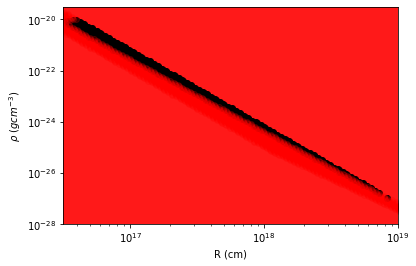

In [13]:
file_in = 'PS11aopfirst_ParameterSpace.csv'
data_plot = ascii.read(file_in)
R = data_plot['Radius']
#gammabeta = data_plot['v_shock']*(1/3e5)



plt.figure()

for i in range(len(data_plot)):
    if data_plot['RuledOut'][i] == 'True':
        plt.plot(R[i],data_plot['den'][i],'ro',alpha=0.2)
    else:
        plt.plot(R[i],data_plot['den'][i],'ko')# label ='PS11aop8')#,alpha=0.2)

plt.yscale('log')
plt.xscale('log')
x =np.linspace(10**(21),10**(16),9)
y1 = np.linspace(10**(-28),10**(-18),9) 

plt.fill_between(x, y1, 0,
                 facecolor="red", # The fill color
                 color='red',       # The outline color
                 alpha=0.9)      
plt.xlim(10**(16.5),10**19)
plt.ylim(10**(-28),10**(-19.5))
plt.xlabel(r'R (cm)',fontsize=10)
plt.ylabel(r'$\rho$ ($gcm^{-3}$)',fontsize=10)
#plt.title('Parameter space for the density profile allowed for PS11aop(8)')
#plt.legend(fontsize=20)
#plt.show()
plt.savefig('PS11aopdrfirst.pdf')

## Make a plot that shows your upper limit and then some examples of SED that are allowed and others that aren't.
(i.e. like the ones you've made before but now with more lines on it. Perhaps color coded based on whether they are allowed or not. I don't think we need to show every single SED that we make in the grid above but more chose say 10ish.)

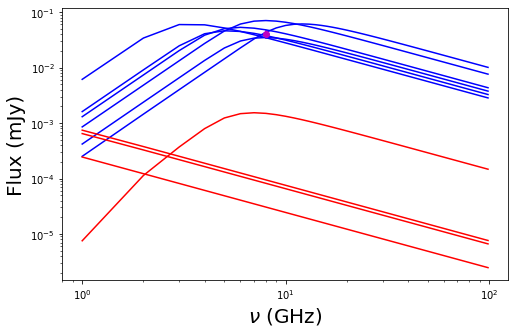

In [15]:
#fitting SED for a second epoch non-detection at 10GHz
data = pd.read_csv('/home/ibik/PS11aopfirst_ParameterSpace.csv')
F_nup1 = data['F_peak'][1] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p1 = data['nu_peak'][1]#.take([0, 3, 14])#[3,5,6])
R1 = data['Radius'][1]#.take([0, 3, 14]) #[3,5,6])
M1 = data['Mdot'][1]#.take([0, 3, 14])
yerr = 0.0075 
t=t_p = 1361.509031 # time of observation in days
D = 1070.1 # distance to SN in Mpc
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2
#nu =np.arange(1, 100, dtype=float)
nu = np.arange(0.005,50,0.01)

        #calculate SSA
SSA_sed1 = F_nup1*1.582*(t/t_p)**a*(nu/nu_p1)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p1)**(-(p+4)/2)))           
#Correct SED for FFA:
Z_ave = 5.4  # Average metallicity 1= pure H. 5.4 for a massive star
miu = 1.9 # mean molecular weight of electrons. 1= pure H  1.9 is for a massive star.
vw_cgs = 100 * 1e5 # assumed wind velocity in cgs (cm/s). Take this as 1000 * 10^5 for now. (i.e. 1000 km/s in cgs)
T = 10**4 # temperature of the material absorbing in K.  10^4 is a good starting point. 

M_cgs1 =  M1 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff1 = 2.021e25*M_cgs1**2*Z_ave/(miu**2*nu**(2.1)*R1**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed1 = SSA_sed1*np.exp(-tau_ff1)

F_nup2 = data['F_peak'][9] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p2 = data['nu_peak'][9]#.take([0, 3, 14])#[3,5,6])
R2 = data['Radius'][9]#.take([0, 3, 14]) #[3,5,6])
M2 = data['Mdot'][9]#.take([0, 3, 14])
SSA_sed2 = F_nup2*1.582*(t/t_p)**a*(nu/nu_p2)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p2)**(-(p+4)/2)))    
M_cgs2 =  M2 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff2 = 2.021e25*M_cgs2**2*Z_ave/(miu**2*nu**(2.1)*R2**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed2 = SSA_sed2*np.exp(-tau_ff2)

F_nup3 = data['F_peak'][18] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p3 = data['nu_peak'][18]#.take([0, 3, 14])#[3,5,6])
R3 = data['Radius'][18]#.take([0, 3, 14]) #[3,5,6])
M3 = data['Mdot'][18]#.take([0, 3, 14])
SSA_sed3 = F_nup3*1.582*(t/t_p)**a*(nu/nu_p3)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p3)**(-(p+4)/2)))    
M_cgs3 =  M3 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff3 = 2.021e25*M_cgs3**2*Z_ave/(miu**2*nu**(2.1)*R3**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed3 = SSA_sed3*np.exp(-tau_ff3)

F_nup4 = data['F_peak'][24] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p4 = data['nu_peak'][24]#.take([0, 3, 14])#[3,5,6])
R4 = data['Radius'][24]#.take([0, 3, 14]) #[3,5,6])
M4 = data['Mdot'][24]#.take([0, 3, 14])
SSA_sed4 = F_nup4*1.582*(t/t_p)**a*(nu/nu_p4)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p4)**(-(p+4)/2)))    
M_cgs4 =  M4 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff4 = 2.021e25*M_cgs4**2*Z_ave/(miu**2*nu**(2.1)*R4**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed4 = SSA_sed4*np.exp(-tau_ff4)

F_nup5 = data['F_peak'][33] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p5 = data['nu_peak'][33]#.take([0, 3, 14])#[3,5,6])
R5 = data['Radius'][33]#.take([0, 3, 14]) #[3,5,6])
M5 = data['Mdot'][33]#.take([0, 3, 14])
SSA_sed5 = F_nup5*1.582*(t/t_p)**a*(nu/nu_p5)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p5)**(-(p+4)/2)))    
M_cgs5 =  M5 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff5 = 2.021e25*M_cgs5**2*Z_ave/(miu**2*nu**(2.1)*R5**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed5 = SSA_sed5*np.exp(-tau_ff5)

F_nup6 = data['F_peak'][41] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p6 = data['nu_peak'][41]#.take([0, 3, 14])#[3,5,6])
R6 = data['Radius'][41]#.take([0, 3, 14]) #[3,5,6])
M6 = data['Mdot'][44]#.take([0, 3, 14])
SSA_sed6 = F_nup6*1.582*(t/t_p)**a*(nu/nu_p6)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p6)**(-(p+4)/2)))    
M_cgs6 =  M2 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff6 = 2.021e25*M_cgs6**2*Z_ave/(miu**2*nu**(2.1)*R6**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed6 = SSA_sed6*np.exp(-tau_ff6)

F_nup7 = data['F_peak'][544] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p7 = data['nu_peak'][544]#.take([0, 3, 14])#[3,5,6])
R7 = data['Radius'][544]#.take([0, 3, 14]) #[3,5,6])
M7 = data['Mdot'][544]#.take([0, 3, 14])
SSA_sed7 = F_nup7*1.582*(t/t_p)**a*(nu/nu_p7)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p7)**(-(p+4)/2)))    
M_cgs7 =  M7 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff7 = 2.021e25*M_cgs7**2*Z_ave/(miu**2*nu**(2.1)*R7**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed7 = SSA_sed7*np.exp(-tau_ff7)

F_nup8 = data['F_peak'][600] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p8 = data['nu_peak'][600]#.take([0, 3, 14])#[3,5,6])
R8 = data['Radius'][600]#.take([0, 3, 14]) #[3,5,6])
M8 = data['Mdot'][600]#.take([0, 3, 14])
SSA_sed8 = F_nup8*1.582*(t/t_p)**a*(nu/nu_p8)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p8)**(-(p+4)/2)))    
M_cgs8 =  M8 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff8 = 2.021e25*M_cgs8**2*Z_ave/(miu**2*nu**(2.1)*R8**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed8 = SSA_sed8*np.exp(-tau_ff8)

F_nup9 = data['F_peak'][650] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p9 = data['nu_peak'][650]#.take([0, 3, 14])#[3,5,6])
R9 = data['Radius'][650]#.take([0, 3, 14]) #[3,5,6])
M9 = data['Mdot'][650]#.take([0, 3, 14])
SSA_sed9 = F_nup9*1.582*(t/t_p)**a*(nu/nu_p9)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p9)**(-(p+4)/2)))    
M_cgs9 =  M9 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff9 = 2.021e25*M_cgs9**2*Z_ave/(miu**2*nu**(2.1)*R9**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed9 = SSA_sed9*np.exp(-tau_ff9)


F_nup10 = data['F_peak'][720] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p10 = data['nu_peak'][720]#.take([0, 3, 14])#[3,5,6])
R10 = data['Radius'][720]#.take([0, 3, 14]) #[3,5,6])
M10 = data['Mdot'][720]#.take([0, 3, 14])
SSA_sed10 = F_nup10*1.582*(t/t_p)**a*(nu/nu_p10)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p10)**(-(p+4)/2)))    
M_cgs10 =  M10 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff10 = 2.021e25*M_cgs10**2*Z_ave/(miu**2*nu**(2.1)*R10**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed10 = SSA_sed10*np.exp(-tau_ff10)


plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,5))

plt.xscale('log')
plt.yscale('log')

plt.plot(nu,SSA_FFA_sed1,'b', nu,SSA_FFA_sed2,'b',nu,SSA_FFA_sed3,'b',nu,SSA_FFA_sed4,'b',nu,SSA_FFA_sed5,'b',nu,SSA_FFA_sed6,'b',nu,SSA_FFA_sed7,'r',nu,SSA_FFA_sed8,'r',nu,SSA_FFA_sed9,'r',nu,SSA_FFA_sed10,'r',label ='PS11aopx')
plt.errorbar(8,0.0404,yerr,fmt ='mo')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)

        #plt.show()
plt.autoscale()
#plt.title('SEDs for PS11aop(10)')   
plt.savefig('PS11aopfirst.pdf')
        
      #  print(F,nu,R,B,v,M,Rule)A
   

/home/ibik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


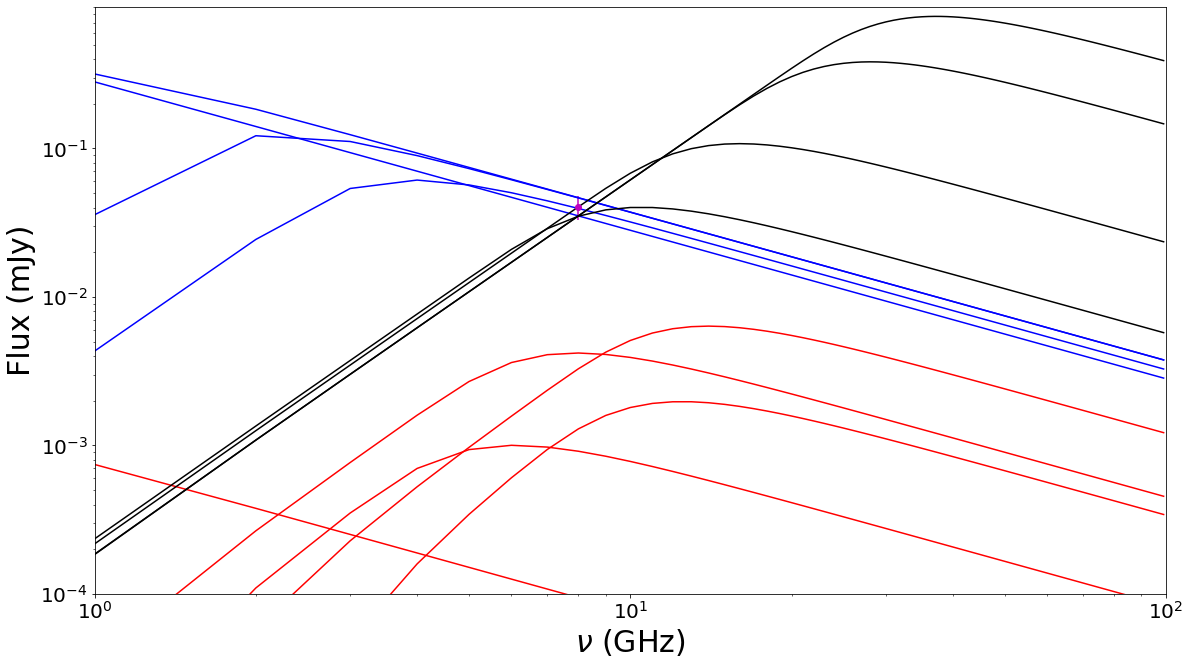

In [3]:
#for the detection
data = pd.read_csv('/home/ibik/firstandsecond.csv')
#data2 = pd.read_csv('/home/ibik/ps11aop2epoch.csv')
F_nup1 = data['F_peak'][104] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p1 = data['nu_peak'][104]#.take([0, 3, 14])#[3,5,6])
R1 = data['Radius'][104]#.take([0, 3, 14]) #[3,5,6])
M1 = data['Mdot'][104]#.take([0, 3, 14])
t = 2800
t=t_p = 1261.509031 # time of observation in days
D = 1088.1 # distance to SN in Mpc
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2
nu =np.arange(1, 100, dtype=float)
        #calculate SSA
SSA_sed1 = F_nup1*1.582*(t/t_p)**a*(nu/nu_p1)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p1)**(-(p+4)/2)))           
#Correct SED for FFA:
Z_ave = 5.4  # Average metallicity 1= pure H. 5.4 for a massive star
miu = 1.9 # mean molecular weight of electrons. 1= pure H  1.9 is for a massive star.
vw_cgs = 100 * 1e5 # assumed wind velocity in cgs (cm/s). Take this as 1000 * 10^5 for now. (i.e. 1000 km/s in cgs)
T = 10**4 # temperature of the material absorbing in K.  10^4 is a good starting point. 

M_cgs1 =  M1 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff1 = 2.021e25*M_cgs1**2*Z_ave/(miu**2*nu**(2.1)*R1**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed1 = SSA_sed1*np.exp(-tau_ff1)

F_nup2 = data['F_peak'][105] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p2 = data['nu_peak'][105]#.take([0, 3, 14])#[3,5,6])
R2 = data['Radius'][105]#.take([0, 3, 14]) #[3,5,6])
M2 = data['Mdot'][105]#.take([0, 3, 14])
SSA_sed2 = F_nup2*1.582*(t/t_p)**a*(nu/nu_p2)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p2)**(-(p+4)/2)))    
M_cgs2 =  M2 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff2 = 2.021e25*M_cgs2**2*Z_ave/(miu**2*nu**(2.1)*R2**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed2 = SSA_sed2*np.exp(-tau_ff2)

F_nup3 = data['F_peak'][106] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p3 = data['nu_peak'][106]#.take([0, 3, 14])#[3,5,6])
R3 = data['Radius'][106]#.take([0, 3, 14]) #[3,5,6])
M3 = data['Mdot'][106]#.take([0, 3, 14])
SSA_sed3 = F_nup3*1.582*(t/t_p)**a*(nu/nu_p3)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p3)**(-(p+4)/2)))    
M_cgs3 =  M3 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff3 = 2.021e25*M_cgs3**2*Z_ave/(miu**2*nu**(2.1)*R3**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed3 = SSA_sed3*np.exp(-tau_ff3)

F_nup4 = data['F_peak'][107] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p4 = data['nu_peak'][107]#.take([0, 3, 14])#[3,5,6])
R4 = data['Radius'][107]#.take([0, 3, 14]) #[3,5,6])
M4 = data['Mdot'][107]#.take([0, 3, 14])
SSA_sed4 = F_nup4*1.582*(t/t_p)**a*(nu/nu_p4)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p4)**(-(p+4)/2)))    
M_cgs4 =  M4 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff4 = 2.021e25*M_cgs4**2*Z_ave/(miu**2*nu**(2.1)*R4**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed4 = SSA_sed4*np.exp(-tau_ff4)

F_nup5 = data['F_peak'][108] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p5 = data['nu_peak'][108]#.take([0, 3, 14])#[3,5,6])
R5 = data['Radius'][108]#.take([0, 3, 14]) #[3,5,6])
M5 = data['Mdot'][108]#.take([0, 3, 14])
SSA_sed5 = F_nup5*1.582*(t/t_p)**a*(nu/nu_p5)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p5)**(-(p+4)/2)))    
M_cgs5 =  M5 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff5 = 2.021e25*M_cgs5**2*Z_ave/(miu**2*nu**(2.1)*R5**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed5 = SSA_sed5*np.exp(-tau_ff5)

F_nup6 = data['F_peak'][0] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p6 = data['nu_peak'][0]#.take([0, 3, 14])#[3,5,6])
R6 = data['Radius'][0]#.take([0, 3, 14]) #[3,5,6])
M6 = data['Mdot'][0]#.take([0, 3, 14])
SSA_sed6 = F_nup6*1.582*(t/t_p)**a*(nu/nu_p6)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p6)**(-(p+4)/2)))    
M_cgs6 =  M2 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff6 = 2.021e25*M_cgs6**2*Z_ave/(miu**2*nu**(2.1)*R6**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed6 = SSA_sed6*np.exp(-tau_ff6)

F_nup7 = data['F_peak'][27] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p7 = data['nu_peak'][27]#.take([0, 3, 14])#[3,5,6])
R7 = data['Radius'][27]#.take([0, 3, 14]) #[3,5,6])
M7 = data['Mdot'][27]#.take([0, 3, 14])
SSA_sed7 = F_nup7*1.582*(t/t_p)**a*(nu/nu_p7)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p7)**(-(p+4)/2)))    
M_cgs7 =  M7 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff7 = 2.021e25*M_cgs7**2*Z_ave/(miu**2*nu**(2.1)*R7**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed7 = SSA_sed7*np.exp(-tau_ff7)

F_nup8 = data['F_peak'][61] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p8 = data['nu_peak'][61]#.take([0, 3, 14])#[3,5,6])
R8 = data['Radius'][61]#.take([0, 3, 14]) #[3,5,6])
M8 = data['Mdot'][61]#.take([0, 3, 14])
SSA_sed8 = F_nup8*1.582*(t/t_p)**a*(nu/nu_p8)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p8)**(-(p+4)/2)))    
M_cgs8 =  M8 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff8 = 2.021e25*M_cgs8**2*Z_ave/(miu**2*nu**(2.1)*R8**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed8 = SSA_sed8*np.exp(-tau_ff8)

F_nup9 = data['F_peak'][48] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p9 = data['nu_peak'][48]#.take([0, 3, 14])#[3,5,6])
R9 = data['Radius'][48]#.take([0, 3, 14]) #[3,5,6])
M9 = data['Mdot'][48]#.take([0, 3, 14])
SSA_sed9 = F_nup9*1.582*(t/t_p)**a*(nu/nu_p9)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p9)**(-(p+4)/2)))    
M_cgs9 =  M9 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff9 = 2.021e25*M_cgs9**2*Z_ave/(miu**2*nu**(2.1)*R9**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed9 = SSA_sed9*np.exp(-tau_ff9)


F_nup10 = data['F_peak'][97] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p10 = data['nu_peak'][97]#.take([0, 3, 14])#[3,5,6])
R10 = data['Radius'][97]#.take([0, 3, 14]) #[3,5,6])
M10 = data['Mdot'][97]#.take([0, 3, 14])
SSA_sed10 = F_nup10*1.582*(t/t_p)**a*(nu/nu_p10)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p10)**(-(p+4)/2)))    
M_cgs10 =  M10 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff10 = 2.021e25*M_cgs10**2*Z_ave/(miu**2*nu**(2.1)*R10**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed10 = SSA_sed10*np.exp(-tau_ff10)

F_nup11 = data['F_peak'][100] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p11 = data['nu_peak'][100]#.take([0, 3, 14])#[3,5,6])
R11 = data['Radius'][100]#.take([0, 3, 14]) #[3,5,6])
M11 = data['Mdot'][100]#.take([0, 3, 14])
SSA_sed11 = F_nup11*1.582*(t/t_p)**a*(nu/nu_p11)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p11)**(-(p+4)/2)))    
M_cgs11 =  M11 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff11 = 2.021e25*M_cgs11**2*Z_ave/(miu**2*nu**(2.1)*R11**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed11 = SSA_sed11*np.exp(-tau_ff11)


F_nup12 = data['F_peak'][87] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p12 = data['nu_peak'][87]#.take([0, 3, 14])#[3,5,6])
R12 = data['Radius'][87]#.take([0, 3, 14]) #[3,5,6])
M12 = data['Mdot'][87]#.take([0, 3, 14])
SSA_sed12 = F_nup12*1.582*(t/t_p)**a*(nu/nu_p12)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p12)**(-(p+4)/2)))    
M_cgs12 =  M12 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff12 = 2.021e25*M_cgs12**2*Z_ave/(miu**2*nu**(2.1)*R12**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed12 = SSA_sed12*np.exp(-tau_ff12)

F_nup13 = data['F_peak'][92] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p13 = data['nu_peak'][92]#.take([0, 3, 14])#[3,5,6])
R13 = data['Radius'][92]#.take([0, 3, 14]) #[3,5,6])
M13 = data['Mdot'][92]#.take([0, 3, 14])
SSA_sed13 = F_nup13*1.582*(t/t_p)**a*(nu/nu_p13)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p13)**(-(p+4)/2)))    
M_cgs13 =  M13 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff13 = 2.021e25*M_cgs13**2*Z_ave/(miu**2*nu**(2.1)*R13**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed13 = SSA_sed13*np.exp(-tau_ff13)


plt.figure(figsize=(19.20,10.80))
plt.rcParams.update({'font.size': 10})
plt.autoscale()
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
yerr = 0.0075 
plt.ylim(10**(-4),0.9)
plt.xlim(1,100)
#plt.errorbar(6,0.0318,yerr,fmt ='o')#'ro', markersize=10)
plt.plot(nu,SSA_FFA_sed1,'r', nu,SSA_FFA_sed2,'r',nu,SSA_FFA_sed3,'r',nu,SSA_FFA_sed4,'r',nu,SSA_FFA_sed5,'r',nu,SSA_FFA_sed6,'b',nu,SSA_FFA_sed7,'b',nu,SSA_FFA_sed8,'b',nu,SSA_FFA_sed9,'b',nu,SSA_FFA_sed10,'k',nu,SSA_FFA_sed11,'k',nu,SSA_FFA_sed12,'k',nu,SSA_FFA_sed13,'k',label ='PS11aop8')
plt.errorbar(8,0.0404,yerr,fmt ='mo')
    
#plt.plot(8,0.0404, 'mo', markersize=10)
plt.xlabel(r'$\nu$ (GHz)', fontsize=30) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=30) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)

        
plt.tick_params(labelsize = 20)
#plt.title('SEDs models for first and second epoch detections for PS1-11aop')   
#plt.savefig('PS11aopxdetect_1c.png', dpi = 300, transparent=True)
plt.show()

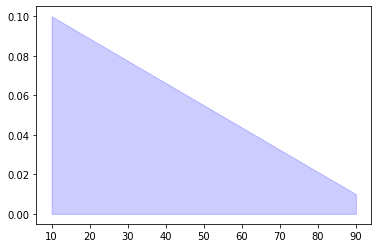

In [24]:
#x =[10,20,30,40,50,60,70,80,90]
x =[90,80,70,60,50,40,30,20,10]
y1 = np.linspace(10**(-2),10**(-1),9) 

plt.fill_between(x, y1, 0,
                 facecolor="orange", # The fill color
                 color='blue',       # The outline color
                 alpha=0.2)       
plt.show()

In [10]:
 print(data['F_peak'].take([0, 3, 14]))

0     0.01
3     0.01
14    0.01
Name: F_peak, dtype: float64
